In [5]:
execfile(r'D:\measuring\analysis\scripts\setup_analysis.py')
folder=tb.latest_data('SPCorrs')
name = 'ssro'
a = pqsequence.TailAnalysis(folder, hdf5_mode='r')#, pq_folder='bs_remote')
#agrp=a.adwingrp('ssro')
print folder
%matplotlib inline

d:\measuring\data
d:\measuring\data\20160518\140038_Purification_111no2_SIL2_SPCorrs


(<matplotlib.figure.Figure at 0x10b76430>,
 (<matplotlib.axes._subplots.AxesSubplot at 0x10b6edd0>,
  <matplotlib.axes._subplots.AxesSubplot at 0xfcf2850>))

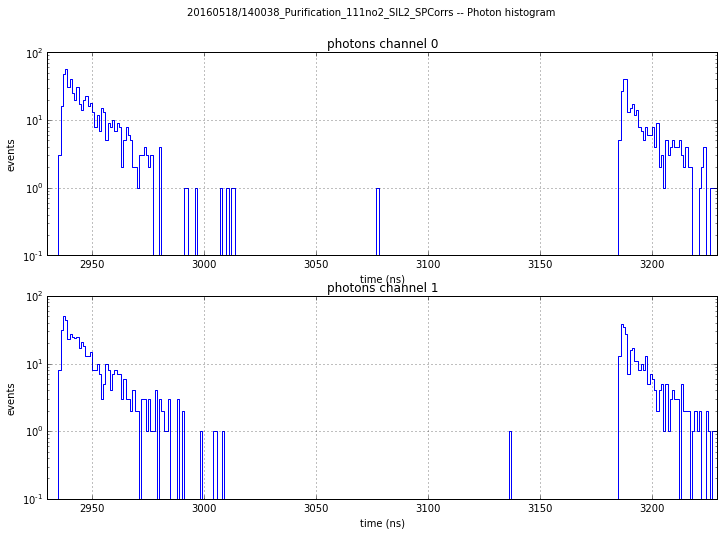

In [14]:
pq_plots.plot_photon_hist(a.pqf,start = 2930E3,  length = 300E3, hist_binsize = 1E3, save = False, log=True)

In [15]:
ro_channel    = 0
photon_channel = 1
ro_start      = 6100
ro_length     = 3700

st_start = 7480 if 'lt3' in a.name else 5440

if photon_channel == 1:
    st_start = 5449
st_len       = 30 #50 ns
st_len_w2    = 30
p_sep        = 550 #600 ns
print st_start

5449


In [237]:
sp_lt = a.pqf['/PQ_special-1'].value      
ch_lt = a.pqf['/PQ_channel-1'].value
sn_lt = a.pqf['/PQ_sync_number-1'].value
st_lt = a.pqf['/PQ_sync_time-1'].value
#tt_lt = a.pqf['/PQ_time-1'].value 

In [238]:
st_fltr_w1 = (sp_lt == 0) & (ch_lt == photon_channel)  & (st_lt > st_start)  & (st_lt < (st_start  + st_len)) 
st_fltr_w2 = (sp_lt == 0) & (ch_lt == photon_channel)  & (st_lt > st_start + p_sep)  & (st_lt < (st_start + p_sep + st_len_w2)) 
fltr_ro    = (sp_lt == 0) & (ch_lt == ro_channel)  & (st_lt > ro_start)  & (st_lt < (ro_start  + ro_length))     

In [239]:
noof_reps = len(np.unique(sn_lt))
noof_reps2= agrp['completed_reps'].value*a.g['joint_params'].attrs['LDE_attempts_before_CR']
ro0_sn = sn_lt[fltr_ro]
noof_ro0 = np.sum(fltr_ro)
w1_sn = sn_lt[st_fltr_w1]
w2_sn = sn_lt[st_fltr_w2]
noof_w1_ro0 = np.sum(np.in1d(w1_sn,ro0_sn))
noof_w2_ro0 = np.sum(np.in1d(w2_sn,ro0_sn))
noof_w1 = np.sum(st_fltr_w1)
noof_w2 = np.sum(st_fltr_w2)

In [240]:
print noof_reps,noof_reps2, noof_ro0, noof_w1_ro0, noof_w2_ro0, noof_w1, noof_w2
print 'tail_cts', float(noof_w1+noof_w2)/noof_reps*1e4

779849 1250000 3170761 3 99 117 106
tail_cts 2.85952793425


In [241]:
ssro_calib_folder  = tb.latest_data('FastSSRO')
try:
#     raise IOError('')
    F0,u_F0, F1, u_F1 = pqsequence.get_analysed_fast_ssro_calibration(ssro_calib_folder, readout_time=None, sweep_index=None)
except IOError:
    print 'FastSSRO calibration not found'
    F0,u_F0, F1, u_F1 = (0.94,0.005, 0.99, 0.005)
ssro_fids = (F0,u_F0, F1, u_F1)

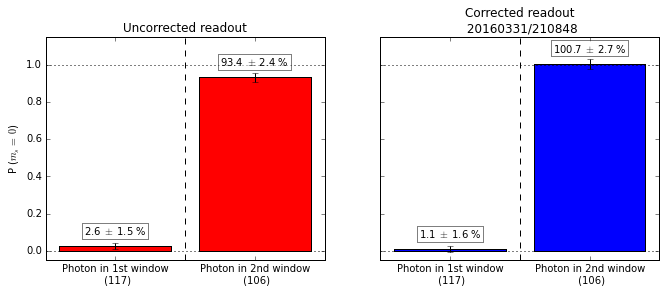

In [242]:
# P_ms1 generally stands for the probability to measure ms=1
# P_photon is the probability for getting a photon
win1_P_photon = float(noof_w1_ro0)/noof_w1
u_win1_P_photon = np.sqrt(win1_P_photon * (1.-win1_P_photon)/noof_w1)

win2_P_photon = float(noof_w2_ro0)/noof_w2
u_win2_P_photon = np.sqrt(win2_P_photon * (1.-win2_P_photon)/noof_w2)

fig, (ax, ax_corr) = plt.subplots(1,2, figsize=(11,4),
                              sharex=True, sharey=True)

### uncorrected for e-SSRO
ax.bar(range(2), [win1_P_photon, win2_P_photon], color=['r', 'r'],
       align='center', yerr=[u_win1_P_photon, u_win2_P_photon], ecolor='k',
       width=0.8)

ax.set_xlim(-0.5,1.5)
ax.set_ylim(-0.05, 1.15)

ax.set_ylabel('P ($m_s =\, 0$)')

ax.set_xticks([0,1])
ax.set_xticklabels(['Photon in 1st window \n ({})'.format(noof_w1),
                    'Photon in 2nd window \n ({})'.format(noof_w2)])
ax.axvline(0.5, c='k', ls='--')
ax.axhline(0, c='k', ls=':')
ax.axhline(1, c='k', ls=':')

ax.text(0, win1_P_photon + 0.05, "{:.1f} $\pm$ {:.1f} %".format(win1_P_photon*100, u_win1_P_photon*100),
        va='bottom', ha='center',
        bbox = {'facecolor' : 'white', 'alpha' : 0.5})
ax.text(1, win2_P_photon + 0.05, "{:.1f} $\pm$ {:.1f} %".format(win2_P_photon*100, u_win2_P_photon*100),
        va='bottom', ha='center',
        bbox = {'facecolor' : 'white', 'alpha' : 0.5})
ax.set_title('Uncorrected readout')

### corrected for e-SSRO
win1_P0, u_win1_P0 = roc.single_qubit_outcome_with_ROC_from_fraction(win1_P_photon, u_win1_P_photon, 
                                                                     *ssro_fids)
win2_P0, u_win2_P0 = roc.single_qubit_outcome_with_ROC_from_fraction(win2_P_photon, u_win2_P_photon,
                                                                     *ssro_fids)

ax_corr.bar(range(2), [win1_P0, win2_P0], color=['b','b'],
       align='center', yerr=[u_win1_P0, u_win2_P0], ecolor='k',
       width=0.8)
ax_corr.axvline(0.5, c='k', ls='--')
ax_corr.axhline(0, c='k', ls=':')
ax_corr.axhline(1, c='k', ls=':')

ax_corr.text(0, win1_P0 + 0.05, "{:.1f} $\pm$ {:.1f} %".format(win1_P0*100, u_win1_P0*100),
        va='bottom', ha='center',
        bbox = {'facecolor' : 'white', 'alpha' : 0.5})
ax_corr.text(1, win2_P0 + 0.05, "{:.1f} $\pm$ {:.1f} %".format(win2_P0*100, u_win2_P0*100),
        va='bottom', ha='center',
        bbox = {'facecolor' : 'white', 'alpha' : 0.5})
ax_corr.set_title('Corrected readout \n '+a.timestamp)
#fig.savefig(os.path.join(folder, 'Spin-photon_correlations.png'))



In [243]:
print 'PSB SP corr from date : {}'.format(tb.get_plot_title_from_folder(folder)[:15])
print '\tTail counts : {:.1f} '. format(float(noof_w1+noof_w2)/noof_reps*1e4)
print '\tRatio of photons detected in w1/w2 : {:.1f} %'.format(np.float(noof_w1)/noof_w2*100)
print '\tUncorrected readout : W1 : {:.1f} +/- {:.1f} % & W2 : {:.1f} +/- {:.1f} %'.format(win1_P_photon*100, u_win1_P_photon*100,win2_P_photon*100, u_win2_P_photon*100)
print '\tCorrected readout : W1 : {:.1f} +/- {:.1f} % & W2 : {:.1f} +/- {:.1f} %'.format(win1_P0*100, u_win2_P0*100,win2_P0*100, u_win2_P0*100)

if win2_P_photon>0.925 and win1_P_photon<0.02 and np.abs(np.float(noof_w1)/noof_w2-1)<0.06 and float(noof_w1+noof_w2)/noof_reps*1e4 >1200:
    print 'thresholds are met'
else:
    print 'thresholds are NOT met: compare to 92.5 and 2'

PSB SP corr from date : 20160331/210848
	Tail counts : 2.9 
	Ratio of photons detected in w1/w2 : 110.4 %
	Uncorrected readout : W1 : 2.6 +/- 1.5 % & W2 : 93.4 +/- 2.4 %
	Corrected readout : W1 : 1.1 +/- 2.7 % & W2 : 100.7 +/- 2.7 %
thresholds are NOT met: compare to 92.5 and 2
